### Script reads from fft and mfcc files and trains using logistic regression and knn
* Author: Geunsik Lim <leemgs@gmail.com> 
* Evaluation Environment: Ubuntu 18.04 , Anaconda3 (202002, conda activate cnn), Python 3.6
* Usage: $ python train-classify.py  genres.FFT/ genres.MFCC/
*   - IN: Paths to directories consisting of FFT files, and MFCC files.
*   - OUT: Splits dataset as per code into train and test sets, performs training and tests. Displays classification accuracy along with confusion matrix.


In [1]:
!conda install lightgbm -y


Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::ipywidgets==7.5.1=py_0
  - defaults/linux-64::cryptography==2.9.2=py37h1ba5d50_0
  - defaults/noarch::python-dateutil==2.8.1=py_0
  - defaults/noarch::zipp==3.1.0=py_0
  - defaults/noarch::parso==0.7.0=py_0
  - defaults/linux-64::mkl_fft==1.0.15=py37ha843d7b_0
  - defaults/linux-64::ipython==7.13.0=py37h5ca1d4c_0
  - defaults/noarch::pygments==2.6.1=py_0
  - defaults/linux-64::gast==0.2.2=py37_0
  - defaults/noarch::decorator==4.4.2=py_0
  - defaults/linux-64::astor==0.8.0=py37_0
  - defaults/noarch::jupyter_client==6.1.3=py_0
  - defaults/linux-64::mkl_random==1.1.0=py37hd6b4f25_0
  - defaults/linux-64::pickleshare==0.7.5=py37_0
  - defaults/linux-64::h5py==2.10.0=py37h7918eee_0
  - defaults/noarch::prompt-toolkit==3.0.4=py_0
  - defaults/linux-64::pandocfilters==1.4.2=py37_1
  - defaults/linux-64::traitlets==4.3.3

In [2]:
import itertools

import sklearn 
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgbm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import scipy
import os
import sys
import glob
import numpy as np



Reads FFT-files and prepares X_train and y_train. genre_list must consist of names of folders/genres consisting of the required FFT-files. base_dir must contain genre_list of directories

In [3]:

def read_fft(genre_list, base_dir):
	X = []
	y = []
	for label, genre in enumerate(genre_list):
		# create UNIX pathnames to id FFT-files.
		genre_dir = os.path.join(base_dir, genre, "*.fft.npy")
		# get path names that math genre-dir
		file_list = glob.glob(genre_dir)
		for file in file_list:
			fft_features = np.load(file)
			X.append(fft_features)
			y.append(label)
	
	# print(X)
	# print(y)
	# print(len(X))
	# print(len(y))

	return np.array(X), np.array(y)


Rreads MFCC-files and prepares X_train and y_train.
genre_list must consist of names of folders/genres consisting of the required MFCC-files
base_dir must contain genre_list of directories

In [4]:

def read_ceps(genre_list, base_dir):
	X, y = [], []
	for label, genre in enumerate(genre_list):
		for fn in glob.glob(os.path.join(base_dir, genre, "*.ceps.npy")):
			ceps = np.load(fn)
			num_ceps = len(ceps)
			X.append(np.mean(ceps[int(num_ceps*1/10):int(num_ceps*9/10)], axis=0))
			y.append(label)
	
	return np.array(X), np.array(y)

In [5]:
def train_score(classifier, Xtrain, Xtest, ytrain, ytest):
        train_acc = classifier.score(Xtrain, ytrain)
        test_acc = classifier.score(Xtest, ytest)
        print("Training Data Accuracy: %0.2f" % (train_acc))
        print("Test Data Accuracy:     %0.2f" % (test_acc))
        ypred = classifier.predict(Xtest)
        conf = confusion_matrix(ytest, ypred)
        precision = (conf[0, 0] / (conf[0, 0] + conf[1, 0]))
        recall = (conf[0, 0] / (conf[0, 0] + conf[0, 1]))
        f1_score = 2 * ((precision * recall)/(precision + recall))
        print("Precision:              %0.2f" % precision)
        print("Recall:                 %0.2f" % recall)
        print("F1 Score:                 %0.2f" % f1_score)
        print('\n')


In [6]:
def plot_confusion_matrix(cm, title, genre_list, cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(genre_list))
        plt.xticks(tick_marks, genre_list, rotation=45)
        plt.yticks(tick_marks, genre_list)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

In [7]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix_02(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### From now on,  the program will be started actually. a main routine  is as follows. 


In [8]:
# List of genres (these must be folder names consisting .wav of respective genre in the base_dir) Change list if needed.
# For example, IF YOU WANT TO CLASSIFY ONLY CLASSICAL AND JAZZ,  specify genre_list = ["classical", "jazz"] 
genre_list = ["classical", "hiphop", "jazz", "pop", "rock", "metal"]
#target_names = genre_list

In [9]:
# use FFT
# base_dir_fft  = "genres.FFT/"
#X, y = read_fft(genre_list, base_dir_fft)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)
#print('\n******USING FFT******')

# print("X_train = " + str(len(X_train)), "y_train = " + str(len(y_train)), "X_test = " + str(len(X_test)), "y_test = " + str(len(y_test)))

In [10]:
# use MFCC
base_dir_mfcc = "genres.MFCC/"
X, y = read_ceps(genre_list, base_dir_mfcc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
print('******USING MFCC******')


******USING MFCC******


In [11]:

# print("X_train = " + str(len(X_train)), "y_train = " + str(len(y_train)), "X_test = " + str(len(X_test)), "y_test = " + str(len(y_test)))

print("######## CLASSIFICATION REPORT with Logistic Regression ########")
logistic_classifier = linear_model.LogisticRegression()
logistic_classifier.fit(X_train, y_train)

logistic_predictions = logistic_classifier.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_cm = confusion_matrix(y_test, logistic_predictions)
# print("logistic accuracy (validation set)= " + str(logistic_classifier.best_score_))
print("logistic accuracy (test set)= " + str(logistic_accuracy))
print("logistic confusion matrix:")
print(logistic_cm)

print(classification_report(y_test, logistic_predictions,target_names=genre_list))


######## CLASSIFICATION REPORT with Logistic Regression ########
logistic accuracy (test set)= 0.7266666666666667
logistic confusion matrix:
[[22  0  1  0  0  1]
 [ 0 15  0  3  1  6]
 [ 2  2 13  1  5  0]
 [ 0  2  1 21  2  0]
 [ 1  6  4  1 11  1]
 [ 0  0  0  0  1 27]]
              precision    recall  f1-score   support

   classical       0.88      0.92      0.90        24
      hiphop       0.60      0.60      0.60        25
        jazz       0.68      0.57      0.62        23
         pop       0.81      0.81      0.81        26
        rock       0.55      0.46      0.50        24
       metal       0.77      0.96      0.86        28

    accuracy                           0.73       150
   macro avg       0.72      0.72      0.71       150
weighted avg       0.72      0.73      0.72       150



/var/www/invain/anaconda3/envs/cnn/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


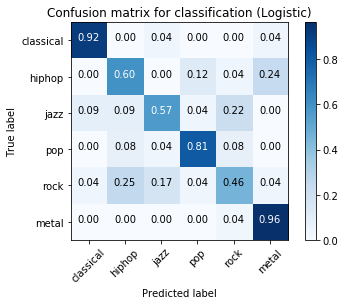

In [12]:
plot_confusion_matrix_02(logistic_cm, genre_list, normalize=True, title="Confusion matrix for classification (Logistic)")

In [13]:
print("######## CLASSIFICATION REPORT with KNeighbors Classifier ########")
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_cm = confusion_matrix(y_test, knn_predictions)

#print("knn accuracy (validation set)= " + str(knn_classifier.best_score_))
print("knn accuracy (test set)= " + str(knn_accuracy))
print("knn confusion matrix:") 
print(knn_cm)

print(classification_report(y_test, knn_predictions,target_names=genre_list))

######## CLASSIFICATION REPORT with KNeighbors Classifier ########
knn accuracy (test set)= 0.6933333333333334
knn confusion matrix:
[[23  0  0  0  1  0]
 [ 0  9  2  3  5  6]
 [ 4  2 13  1  3  0]
 [ 1  1  1 22  1  0]
 [ 1  6  3  1 12  1]
 [ 0  1  0  0  2 25]]
              precision    recall  f1-score   support

   classical       0.79      0.96      0.87        24
      hiphop       0.47      0.36      0.41        25
        jazz       0.68      0.57      0.62        23
         pop       0.81      0.85      0.83        26
        rock       0.50      0.50      0.50        24
       metal       0.78      0.89      0.83        28

    accuracy                           0.69       150
   macro avg       0.67      0.69      0.68       150
weighted avg       0.68      0.69      0.68       150



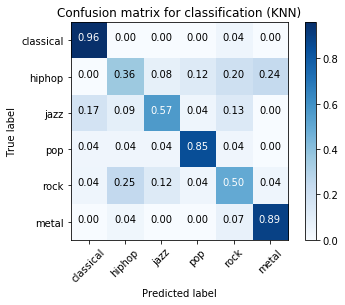

In [14]:
plot_confusion_matrix_02(knn_cm, genre_list, normalize=True, title="Confusion matrix for classification (KNN)")

In [15]:
print("######## CLASSIFICATION REPORT with SVM (Support Vector Machine)########")
params = {
	"cls__C": [0.5, 1, 2, 5],
	"cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
	('scale', StandardScaler()),
	('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
	('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
	('cls', SVC())
])

svm_classifier = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_cm = confusion_matrix(y_test, svm_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)
#print("svm accuracy (validation set)= " + str(svm_classifier.best_score_))
print("svm accuracy (test set)= " + str(svm_accuracy))
print("svm confusion matrix:") 
print(svm_cm)

print(classification_report(y_test, svm_predictions,target_names=genre_list))



######## CLASSIFICATION REPORT with SVM (Support Vector Machine)########
svm accuracy (test set)= 0.7533333333333333
svm confusion matrix:
[[21  0  0  0  3  0]
 [ 0 14  1  3  1  6]
 [ 3  0 17  0  3  0]
 [ 0  1  1 23  1  0]
 [ 0  4  3  1 16  0]
 [ 0  1  1  0  4 22]]
              precision    recall  f1-score   support

   classical       0.88      0.88      0.88        24
      hiphop       0.70      0.56      0.62        25
        jazz       0.74      0.74      0.74        23
         pop       0.85      0.88      0.87        26
        rock       0.57      0.67      0.62        24
       metal       0.79      0.79      0.79        28

    accuracy                           0.75       150
   macro avg       0.75      0.75      0.75       150
weighted avg       0.76      0.75      0.75       150



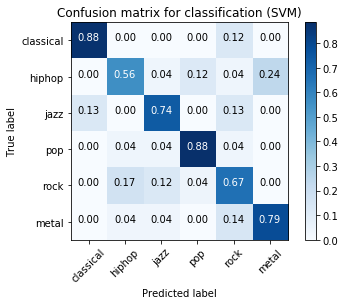

In [16]:
plot_confusion_matrix_02(svm_cm, genre_list, normalize=True, title="Confusion matrix for classification (SVM)")

In [17]:
print ("This lie is last statement. All tasks are successfully done.")

This lie is last statement. All tasks are successfully done.
